In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms, models
import numpy as np 
import os
import joblib
import torch.nn.utils.prune as prune
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224
    transforms.ToTensor(),   # Convert image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
## utils 에넣기
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# For GPU
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
import joblib
import os
##args path에 넣기
saved_path= '/data/ephemeral/home/nathan/saved'
model_name=os.path.join(saved_path,'resnet18.joblib')
model = joblib.load(model_name)

In [5]:
# args 와 criterion에 넣기
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [6]:
# train 풀더에 넣고 모듈화진행 
def train(model,train_loader,num_epochs=10):
    model.train()
    for epochs in range(num_epochs):
        model.train()
        running_loss=0.0
        for images, labels in tqdm(train_loader):
            images,labels= images.to(device),labels.to(device)

            output=model(images)
            loss = criterion(output,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()

        print(f'Epochs: {epochs+1}/{num_epochs} Training loss: {running_loss/len(train_loader)}')
        
def test(model,test_loader,howmany):
    model.eval()
    s=time.time()
    with torch.no_grad():
        total=0
        correct=0
        for images,labels in tqdm(test_loader):
            images,labels= images.to(device),labels.to(device)
            output=model(images)
            _,predicted = torch.max(output,dim=1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
        
        accuracy=100*correct/total
        e=time.time()
        print(f'Accuracy: {accuracy}%, Forward Time: {e - s:.2f}s, pruned_channel: {howmany}')
        get_model_memory_usage(model)

def get_model_memory_usage(model):
    total_params = 0
    total_memory = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            total_memory += param.numel() * param.element_size()  # Bytes

    print(f"Total Parameters: {total_params}")
    print(f"Memory Usage for Parameters: {total_memory / 1e6:.2f} MB")  # Convert to MB

### Structured pruning for CNN 은 2가지로 구분된다
1. CNN (연산속도)-> 학습된 모델에 sentiment analysis 요구 (Filter, )
2. FN (파라미터) 

In [7]:
#sensitivity analysis
sensitivity_layer={}
for name,module in model.named_modules():
    if isinstance(module,nn.Conv2d):
        L1_weight= module.weight.data.cpu().numpy()
        L1_weight=L1_weight.reshape(L1_weight.shape[0],-1)
        L1_weight=np.sort(np.sum(np.abs(L1_weight),axis=1))[::-1]
        L1_weight=L1_weight/L1_weight[0]
        #L2_weight = torch.sqrt(torch.sum(module.weight,dim=(1,2,3)))
        sensitivity_layer[name]=L1_weight
        
    

### sensitivity CNN 시각화

In [8]:
import matplotlib.pyplot as plt
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


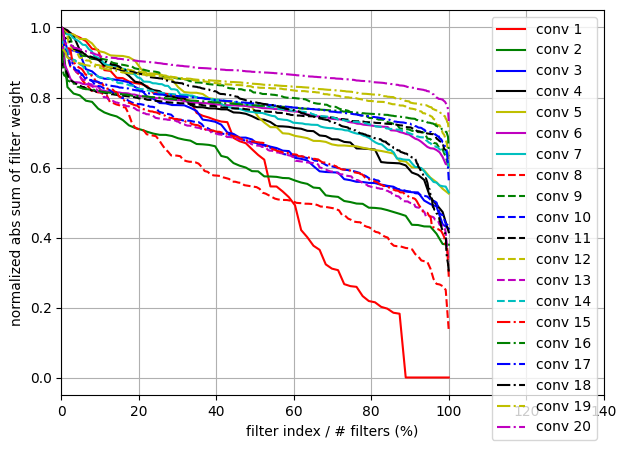

In [9]:
plt.figure(figsize=(7,5))
count=0
for key,sensitivity in sensitivity_layer.items():
    line_style=colors[count%len(colors)]+lines[count//len(colors)]
    x=np.linspace(0,100,num=sensitivity.shape[0])
    y=sensitivity
    count+=1
    print(count)
    plt.plot(x,y,line_style,label='conv %d'%count)
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.show()        

In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### prune 하기

In [11]:
max_ratio=0.9
step_ratio=8

In [12]:
idx2name_module={}
i=0
for name,module in model.named_modules():
    if isinstance(module,nn.Conv2d):
        idx2name_module[i]=(name,module)
        i+=1
    elif isinstance(module,nn.BatchNorm2d):
        idx2name_module[i]=(name,module)
        i+=1
    elif isinstance(module,nn.Linear):
        idx2name_module[i]=(name,module)
        i+=1

In [13]:
idx2name_module


{0: ('conv1',
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 1: ('bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 2: ('layer1.0.conv1',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 3: ('layer1.0.bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 4: ('layer1.0.conv2',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 5: ('layer1.0.bn2',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 6: ('layer1.1.conv1',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 7: ('layer1.1.bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 8: ('layer1.1.conv2',
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
 9: ('layer1.1.bn2',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [14]:
name,conv2 = idx2name_module[2]

In [15]:
name_lst=name.split('.')

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
from prune_function import *
from prune import *
basic=joblib.load(model_name)
idx=0
for name,module in model.named_modules():
    if isinstance(module,nn.Conv2d):
        step=np.linspace(0,int(module.out_channels*max_ratio),step_ratio,dtype=int)
        steps=step[1:]-step[:-1]
        # steps는 얼마만큼의 filter를 제거할꺼인지 정함.
        for i in range(len(steps)//2): 
            # 매번 필터를 제거하는양이 달라서 network부름
            network=joblib.load(model_name)
            num_channel=module.out_channels- sum(steps[:i+1])
            print(name,sum(steps[:i+1]))
            network=prune_step(network,name,num_channel,idx2name_module,index=idx).to(device)
            print("-*-"*10 + "\n\tPrune network\n" + "-*-"*10)
            print(network)
            
            network_name_v='resenet'+'_'+ name +'_'+str(sum(steps[:i+1]))
            network_name=os.path.join(saved_path,network_name_v)

            #joblib.dump(network,network_name)
            test(network,test_loader,sum(steps[:i+1]))
        idx+=2
                
         

conv1 8
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 56, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv2d(56, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]


Accuracy: 20.23%, Forward Time: 21.60s, pruned_channel: 8
Total Parameters: 11179426
Memory Usage for Parameters: 44.72 MB
conv1 16
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv2d(48, 64, kern

100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Accuracy: 28.71%, Forward Time: 22.82s, pruned_channel: 16
Total Parameters: 11173114
Memory Usage for Parameters: 44.69 MB
conv1 24
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 40, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(40, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv2d(40, 64, ker

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Accuracy: 56.56%, Forward Time: 21.17s, pruned_channel: 24
Total Parameters: 11166802
Memory Usage for Parameters: 44.67 MB
layer1.0.conv1 8
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
   

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Accuracy: 95.65%, Forward Time: 21.44s, pruned_channel: 8
Total Parameters: 11172410
Memory Usage for Parameters: 44.69 MB
layer1.0.conv1 16
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
   

100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


Accuracy: 95.54%, Forward Time: 20.91s, pruned_channel: 16
Total Parameters: 11163178
Memory Usage for Parameters: 44.65 MB
layer1.0.conv1 24
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(40, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
  

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


Accuracy: 95.33%, Forward Time: 21.39s, pruned_channel: 24
Total Parameters: 11153946
Memory Usage for Parameters: 44.62 MB
layer1.0.conv2 8
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv2d(64,

100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Accuracy: 9.99%, Forward Time: 21.73s, pruned_channel: 8
Total Parameters: 11179578
Memory Usage for Parameters: 44.72 MB
layer1.0.conv2 16
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv2d(64, 

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]


Accuracy: 10.04%, Forward Time: 21.50s, pruned_channel: 16
Total Parameters: 11169322
Memory Usage for Parameters: 44.68 MB
layer1.0.conv2 24
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Conv2d(64

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


Accuracy: 10.0%, Forward Time: 21.43s, pruned_channel: 24
Total Parameters: 11159066
Memory Usage for Parameters: 44.64 MB
layer1.1.conv1 8
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
    

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


Accuracy: 95.78%, Forward Time: 21.30s, pruned_channel: 8
Total Parameters: 11172410
Memory Usage for Parameters: 44.69 MB
layer1.1.conv1 16
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
   

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Accuracy: 95.74%, Forward Time: 21.18s, pruned_channel: 16
Total Parameters: 11163178
Memory Usage for Parameters: 44.65 MB
layer1.1.conv1 24
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
  

100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Accuracy: 95.58%, Forward Time: 21.45s, pruned_channel: 24
Total Parameters: 11153946
Memory Usage for Parameters: 44.62 MB
layer1.1.conv2 8
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
   

  0%|          | 0/79 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [128, 64, 1, 1], expected input[128, 56, 56, 56] to have 64 channels, but got 56 channels instead

In [26]:
model.layer2[0].downsample[0]




Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)